In [1]:
import os
from dotenv import load_dotenv
import numpy as np
import tensorflow as tf
import pandas as pd
import datetime

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

load_dotenv(override=True)

DATA_PATH = os.getenv('DATA_PATH')
print(DATA_PATH)

# Choose subontology (CCO, MFO or BPO)
SO = 'MFO'

2023-06-03 10:17:52.465861: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 10:17:53.172260: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1
/mnt/e/ML/cafa-5-protein-function-prediction


2023-06-03 10:17:54.514561: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-03 10:17:54.596940: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-03 10:17:54.597259: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.


## Reading fasta, obo and tsv files

In [2]:
from Bio import SeqIO

sequences = [rec.seq for rec in SeqIO.parse(os.path.join(DATA_PATH, "Train/train_sequences.fasta"),"fasta")]
ids = [rec.id for rec in SeqIO.parse(os.path.join(DATA_PATH, "Train/train_sequences.fasta"),"fasta")]

In [3]:
print("There are {} sequences in the dataset.".format(len(sequences)))

There are 142246 sequences in the dataset.


In [4]:
import networkx
import obonet

# Read the taxrank ontology
url = os.path.join(DATA_PATH, "Train/go-basic.obo")
graph = obonet.read_obo(url)



In [5]:
df = pd.read_csv(os.path.join(DATA_PATH, "Train/train_terms.tsv"), sep='\t')

dfSO = df.loc[df["aspect"]==SO]
uniqueTerms = dfSO["term"].unique()
termsArr = list(dfSO["term"].to_numpy())

uniqueTermsDict={}
for i,el in enumerate(uniqueTerms):
    uniqueTermsDict[el] = i
    
print(dfSO.shape)
df=dfSO

(670114, 3)


Test for the first entry:

In [6]:
df.set_index("EntryID", inplace=True)
df.head(10)

,term,aspect
EntryID,,
A0A009IHW8,GO:0003674,MFO
A0A009IHW8,GO:0003953,MFO
A0A009IHW8,GO:0016787,MFO
A0A009IHW8,GO:0016799,MFO
A0A009IHW8,GO:0016798,MFO
A0A009IHW8,GO:0003824,MFO
A0A023FBW4,GO:0019956,MFO
A0A023FBW4,GO:0005488,MFO
A0A023FBW4,GO:0003674,MFO


In [7]:
testID = df.index.to_list()[0]

In [8]:
%timeit df.loc[testID]

20 µs ± 423 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [9]:
df.loc[testID]

,term,aspect
EntryID,,
A0A009IHW8,GO:0003674,MFO
A0A009IHW8,GO:0003953,MFO
A0A009IHW8,GO:0016787,MFO
A0A009IHW8,GO:0016799,MFO
A0A009IHW8,GO:0016798,MFO
A0A009IHW8,GO:0003824,MFO


In [10]:
np.unique(df["aspect"].to_numpy())

array(['MFO'], dtype=object)

## GO analysis

In [11]:
item_counts = df["term"].value_counts()
print(item_counts[0:20])

GO:0003674    78637
GO:0005488    57380
GO:0005515    47987
GO:0003824    25324
GO:0097159    12889
GO:1901363    12694
GO:0003676    10236
GO:0016740     9868
GO:0016787     7887
GO:0140096     7099
GO:0003677     6249
GO:0042802     5630
GO:0043167     5408
GO:0005215     4754
GO:0016491     4571
GO:0022857     4499
GO:0043565     4452
GO:0003723     4189
GO:0016772     4134
GO:0019899     3895
Name: term, dtype: int64


In [12]:
id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}
print(id_to_name['GO:0031981'] )

nuclear lumen


## Label encoding

The task is a multilabel classification: The output has several possible targets (Gene Ontologies) but each can only be 1 (existing) or 0 (non existing)

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer
import pickle

topGOs= item_counts
topGOs=topGOs.index.to_list()

mlb = MultiLabelBinarizer()
mlb.fit([topGOs])

dftest=df.loc[testID]
indices = dftest["term"].to_numpy()
print(indices)
print(mlb.transform([indices]))
print(len(mlb.classes_))

with open(os.path.join(DATA_PATH,'MLB_'+SO+'.pkl'), 'wb') as f:
    pickle.dump(mlb, f)

['GO:0003674' 'GO:0003953' 'GO:0016787' 'GO:0016799' 'GO:0016798'
 'GO:0003824']
[[0 0 0 ... 0 0 0]]
7224


Extract label weights from IA

In [14]:
dfIa = pd.read_csv(os.path.join(DATA_PATH, "IA.txt"), sep='\t', header=None)

dfIa.set_index(0, inplace=True)

labelWeights=[]
allIndices = dfIa.index.tolist()


for go in topGOs:
    if go in allIndices:
        labelWeights.append(dfIa.loc[go].to_numpy()[0])
    else:
        labelWeights.append(1)

In [15]:
len(labelWeights)

7224

## Amino acids encoding

In [16]:
aminos_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'X']

In [17]:
aa_dict = {'A': 1, 'B':24, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 21, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'U': 22, 'V': 18, 'W': 19, 'Y': 20, 'X':30, 'Z':23}

## Build Dataset

In [18]:
seqLengths = [len(seq) for seq in sequences]
maxLen = max(seqLengths)
print("The max. length of the sequences is {}".format(maxLen))

The max. length of the sequences is 35375


In [19]:

dfAll=pd.read_csv(os.path.join(DATA_PATH, "Train/train_terms.tsv"), sep='\t')

soEntries = dfAll.loc[dfAll["aspect"]==SO]
soEntryIds = soEntries["EntryID"].unique()

# print(len(seqEntries))
print(soEntryIds)

SoSequences = []
for entry in soEntryIds:
    SoSequences.append(sequences[ids.index(entry)])

print(len(SoSequences))
dfAll.set_index("EntryID", inplace=True)

['A0A009IHW8' 'A0A023FBW4' 'A0A023FBW7' ... 'X5L1L5' 'X5L565' 'X5M5N0']
78637


In [20]:
import warnings

TRAIN_VAL_SPLIT = 0.7

#Use numpy vectorize to speed up the mapping (hopefully)
mapping = lambda x: aa_dict[x]
vectMapping = np.vectorize(mapping)

# Shuffle the data
import random
random.seed(516213)
c = list(zip(sequences, ids))
random.shuffle(c)
sequencesShuffle, idsShuffle = zip(*c)

#reduce data for now
# sequencesShuffle = sequencesShuffle[0:10000]
# idsShuffle = idsShuffle[0:10000]

#Train Validation Split
split = int(np.floor(len(sequencesShuffle)*TRAIN_VAL_SPLIT))
print(split)
trainSeq = sequencesShuffle[0:split]
valSeq = sequencesShuffle[split+1:]
trainIds = idsShuffle[0:split]
valIds = idsShuffle[split+1:]


def generator(padding=True):
    for i,seq in enumerate(trainSeq):
        entryId = trainIds[i]
        
        if entryId in soEntryIds:
          labelData = df.loc[entryId]
          # indices = labelData["termToken"].to_numpy()
          indices = labelData["term"].to_numpy()
        else:
          indices=[]

        with warnings.catch_warnings():
            #supress the warnings for unknown classes
            warnings.simplefilter("ignore")
            y = mlb.transform([indices])
        
        arr = np.array(seq)
        mappedArr = vectMapping(arr)
        if padding:
            padWidth = maxLen - arr.size
            mappedArr = np.pad(mappedArr, (0, padWidth))
        yield (mappedArr,y[0])

def generatorVal(padding=True):
    for i,seq in enumerate(valSeq):
        entryId = valIds[i]
        if entryId in soEntryIds:
          labelData = df.loc[entryId]
          # indices = labelData["termToken"].to_numpy()
          indices = labelData["term"].to_numpy()
        else:
          indices=[]

        with warnings.catch_warnings():
            #supress the warnings for unknown classes
            warnings.simplefilter("ignore")
            y = mlb.transform([indices])
        
        arr = np.array(seq)
        mappedArr = vectMapping(arr)
        if padding:
            padWidth = maxLen - arr.size
            mappedArr = np.pad(mappedArr, (0, padWidth))
        yield (mappedArr,y[0])
        

99572


In [21]:
g = generator()
test = next(g)
print("The first sample: {}".format(test))
print("The first sample has {} classes".format(np.count_nonzero(test[1])))

The first sample: (array([11, 16,  3, ...,  0,  0,  0]), array([0, 0, 0, ..., 0, 0, 0]))
The first sample has 7 classes


## Tensorflow Classification

In [22]:
import tensorflow as tf


dataset = tf.data.Dataset.from_generator(generator, output_signature=(
         tf.TensorSpec(shape=(maxLen,), dtype=tf.int32),
         tf.TensorSpec(shape=(len(mlb.classes_),), dtype=tf.int32)))
print(list(dataset.take(1)))

datasetVal = tf.data.Dataset.from_generator(generatorVal, output_signature=(
         tf.TensorSpec(shape=(None,), dtype=tf.int32),
         tf.TensorSpec(shape=(len(mlb.classes_),), dtype=tf.int32)))

[(<tf.Tensor: shape=(35375,), dtype=int32, numpy=array([11, 16,  3, ...,  0,  0,  0], dtype=int32)>, <tf.Tensor: shape=(7224,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>)]


2023-06-03 10:18:48.239871: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-03 10:18:48.240246: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-03 10:18:48.240582: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-03 10:18:49.003235: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-03 10:18:49.003580: I tensorflow/compile

In [23]:
%load_ext tensorboard


In [24]:
from tensorflow.keras import layers

VOCAB_SIZE=len(aa_dict)
EMBED_DIM=100

def createModel():
    inputs = tf.keras.Input(shape=(maxLen,))
    x=layers.Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True, name="embedding")(inputs)
    x=layers.GlobalAveragePooling1D()(x)
    x=layers.Reshape((EMBED_DIM,1))(x)
    x=layers.Conv1D(8, 7, activation=tf.keras.activations.relu)(x)
    x=layers.Conv1D(8, 7, activation=tf.keras.activations.relu)(x)
    x=layers.Conv1D(8, 7, activation=tf.keras.activations.relu)(x)
    x=layers.Conv1D(16, 7, activation=tf.keras.activations.relu)(x)
    x=layers.Conv1D(16, 7, activation=tf.keras.activations.relu)(x)
    x=layers.Conv1D(16, 7, strides=2)(x)
    # x=layers.Conv1D(32, 5, activation=tf.keras.activations.relu)(x)
    # x=layers.Conv1D(32, 5, activation=tf.keras.activations.relu)(x)
    # x=layers.Conv1D(32, 5, activation=tf.keras.activations.relu)(x)
    x=layers.Flatten()(x)
    x=layers.Dense(16)(x)
    x=layers.LeakyReLU()(x)
    x=layers.Dense(16)(x)
    x=layers.LeakyReLU()(x)
    outputs=layers.Dense(len(mlb.classes_), activation=tf.keras.activations.sigmoid)(x)
    # outputs=layers.Softmax()(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name="embedConvModel")

# model = createModel()

# model.summary()


In [25]:

VOCAB_SIZE=len(aa_dict)
EMBED_DIM=100

def createRnnModel():
    inputs = tf.keras.Input(shape=(maxLen,))
    # x = tf.keras.layers.Masking(0)(inputs)
    x=layers.Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True, name="embedding")(inputs)

    # x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)
    # x = layers.Bidirectional(layers.GRU(16, return_sequences=True))(x)
    # x = layers.Bidirectional(layers.GRU(16))(x)
    x = layers.LSTM(32)(x)
    x = layers.Dense(32)(x)
    x = layers.LeakyReLU()(x)
    outputs=layers.Dense(len(mlb.classes_), activation=tf.keras.activations.sigmoid)(x)
    # outputs=layers.Softmax()(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name="embedRnnModel")

model = createRnnModel()

model.summary()

Model: "embedRnnModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 35375)]           0         
                                                                 
 embedding (Embedding)       (None, 35375, 100)        2500      
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 7224)              238392    
                                                                 
Total params: 258,972
Trainable params: 258,972
Non-t

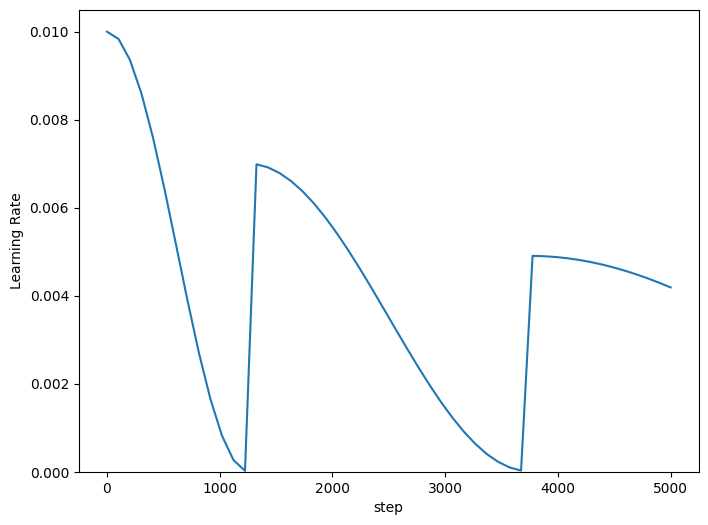

In [26]:
import matplotlib.pyplot as plt
#Learning rate schedule
initial_learning_rate = 0.01
decaySteps=5000
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate, first_decay_steps=decaySteps/4,
                                                                t_mul=2.0, m_mul=0.7, alpha=0.001)
# lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate, decay_steps=decaySteps, alpha=0.01)
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,decay_steps=decaySteps,decay_rate=0.9,staircase=False)
step = np.linspace(0,decaySteps)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
# plt.yscale("log")
plt.plot(step, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('step')
_ = plt.ylabel('Learning Rate')

In [27]:
from tensorflow.keras.losses import Loss

class WeightedBinaryCE(Loss):
    # initialize instance attributes
    def __init__(self, classWeights, labelSmoothing=0.0):
        super(WeightedBinaryCE, self).__init__()
        self.labelSmoothing = tf.constant(labelSmoothing, dtype=tf.dtypes.float32)
        self.classWeights= tf.constant(classWeights, dtype=tf.dtypes.float32)
        
    # Compute loss
    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        if(self.labelSmoothing>0):
            y_true = y_true*(1-self.labelSmoothing)+self.labelSmoothing/2
        y_pred = tf.cast(y_pred, tf.float32)
        y_pred = tf.clip_by_value(y_pred,tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        term_0 = tf.math.multiply(self.classWeights * tf.math.subtract(1.0 , y_true), tf.math.log(tf.math.subtract(1.0, y_pred) + tf.keras.backend.epsilon()))
        term_1 = tf.math.multiply(self.classWeights * y_true, tf.math.log(y_pred + tf.keras.backend.epsilon()))
        losses = term_0 + term_1
        return -tf.reduce_mean(losses, axis=0)
    

testLoss = WeightedBinaryCE([1,1,1])
labelsTrue = tf.constant([[1,0,1], [1,1,0]])
labelsPred = tf.constant([[0.42,0.111,0.957], [0.877,0.121,0.544]])

print(testLoss(labelsTrue, labelsPred))
kerasCE = tf.keras.losses.BinaryCrossentropy()
print(kerasCE(labelsTrue, labelsPred))


tf.Tensor(0.6762641, shape=(), dtype=float32)
tf.Tensor(0.6762641, shape=(), dtype=float32)


In [28]:


class WeightedF1(tf.keras.metrics.Metric):
    def __init__(self, classWeights, threshold=0.5):
        super(WeightedF1, self).__init__()
        self.classWeights= tf.constant(classWeights, dtype=tf.dtypes.float32)
        self.threshold= tf.constant(threshold, dtype=tf.dtypes.float32)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.total = self.add_weight('total', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        m = tf.math.count_nonzero(tf.reduce_min(y_pred, axis=1))
        n = tf.shape(y_pred)[0]
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.math.greater_equal(y_pred,self.threshold)
   

        tp = tf.math.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
        tp = tf.cast(tp, self.dtype)
        tp = tf.math.multiply(tp, self.classWeights)
        tp = tf.cast(tp, self.dtype)

        tn = tf.math.logical_and(tf.equal(y_true, False), tf.equal(y_pred, False))
        tn = tf.cast(tn, self.dtype)
        tn = tf.math.multiply(tn, self.classWeights)
        tn = tf.cast(tn, self.dtype)

        fp = tf.math.logical_and(tf.equal(y_true, True), tf.equal(y_pred, False))
        fp = tf.cast(fp, self.dtype)
        fp = tf.math.multiply(fp, self.classWeights)
        fp = tf.cast(fp, self.dtype)

        fn = tf.math.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True))
        fn = tf.cast(fn, self.dtype)
        fn = tf.math.multiply(fn, self.classWeights)
        fn = tf.cast(fn, self.dtype)

        pr = tf.math.divide(tf.math.reduce_sum(tp, axis=1),tf.math.reduce_sum(tp+fp+tf.keras.backend.epsilon(), axis=1))
        m = tf.cast(m, pr.dtype)
        if(m>0):
            wPr = tf.math.reduce_sum(pr)/m
        else:
            wPr = tf.constant(0, tf.dtypes.float32)

        re = tf.math.divide(tf.math.reduce_sum(tp, axis=1),tf.math.reduce_sum(tp+fn+tf.keras.backend.epsilon(), axis=1))
        n = tf.cast(n, re.dtype)
        wRe = tf.math.reduce_sum(re)/n

        res = tf.math.divide(2*wPr*wRe, wPr + wRe + tf.keras.backend.epsilon())

        self.f1.assign_add(res)
        self.total.assign_add(1)

    def result(self):
        return tf.math.divide(self.f1, self.total)

testM = WeightedF1(classWeights=[1,1,2])
labelsTrue = tf.constant([[1,0,1], [1,1,0]])
labelsPred = tf.constant([[0.8,0.1,0.9], [0.9,0.9,0.6]])

testM.update_state(labelsTrue, labelsPred)
testM.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.85714275>

In [29]:
# BATCH_SIZE=32

# batchedDataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
# batchedDatasetVal = datasetVal.batch(BATCH_SIZE, drop_remainder=False)

# batchedDataset = batchedDataset.cache(os.path.join(DATA_PATH, "datasetCache"+SO))
# batchedDatasetVal = batchedDatasetVal.cache(os.path.join(DATA_PATH, "datasetCacheVal"+SO))

# optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule)

# loss_fn = WeightedBinaryCE(labelWeights)

# train_acc_metric = tf.keras.metrics.BinaryAccuracy()
# train_f1_metric = WeightedF1(classWeights=labelWeights, threshold=0.5)
# train_prec = tf.keras.metrics.Precision()
# train_rec = tf.keras.metrics.Recall()

# model.compile(optimizer, loss_fn, metrics=[train_acc_metric,train_prec,train_f1_metric,train_rec ])

# model.fit(batchedDataset, epochs=1, validation_data=batchedDatasetVal)

In [30]:
# import tensorflow_addons as tfa

BATCH_SIZE=16
LOG_INTERVAL=10
epochs = 10
saveModel=False


log_dir = "./logs/"+model.name+"/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+"_"+SO
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,
                                                      write_graph=True, update_freq=5)


summary_writer = tf.summary.create_file_writer(log_dir)

# Instantiate an optimizer .
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule)

# Instantiate a loss function.
# loss_fn = tf.keras.losses.BinaryCrossentropy()
# loss_fn = WeightedBinaryCE(np.ones(len(mlb.classes_)))
loss_fn = WeightedBinaryCE(labelWeights)

train_acc_metric = tf.keras.metrics.BinaryAccuracy()
train_f1_metric = WeightedF1(classWeights=labelWeights, threshold=0.5)
train_prec = tf.keras.metrics.Precision()
train_rec = tf.keras.metrics.Recall()
# train_f1_metric = tfa.metrics.F1Score(num_classes=len(mlb.classes_), threshold=0.5, average="macro")

val_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_f1_metric = WeightedF1(classWeights=labelWeights, threshold=0.5)
# val_f1_metric = tfa.metrics.F1Score(num_classes=len(mlb.classes_), threshold=0.5, average="macro")
val_prec = tf.keras.metrics.Precision()
val_rec = tf.keras.metrics.Recall()

batchedDataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
batchedDatasetVal = datasetVal.batch(BATCH_SIZE, drop_remainder=False)

# batchedDataset = batchedDataset.cache(os.path.join(DATA_PATH, "datasetCache"+SO))
# batchedDatasetVal = batchedDatasetVal.cache(os.path.join(DATA_PATH, "datasetCacheVal"+SO))

# @tf.function()
def trainStep(x_batch_train, y_batch_train):
    # Open a GradientTape to record the operations run
    # during the forward pass, which enables auto-differentiation.
    with tf.GradientTape() as tape:

        # Run the forward pass of the layer.
        # The operations that the layer applies
        # to its inputs are going to be recorded
        # on the GradientTape.
        probs = model(x_batch_train, training=True) 

        # Compute the loss value for this minibatch.
        loss_value = loss_fn(y_batch_train, probs)

    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.
    grads = tape.gradient(loss_value, model.trainable_weights)
    #Gradient clipping
    # grads = [tf.clip_by_norm(g, 2.0) for g in grads]

    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss.
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    
    return loss_value, probs

maxStep=0

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch+1,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(batchedDataset):

        loss_value, probs=trainStep(x_batch_train,y_batch_train)

        train_acc_metric.update_state(y_batch_train, probs)
        train_f1_metric.update_state(y_batch_train, probs)
        train_prec.update_state(y_batch_train, probs)
        train_rec.update_state(y_batch_train, probs)

        # Log 
        if step % LOG_INTERVAL == 0:
            template = 'Epoch {}/Step {}, Loss: {:.5f}, Accuracy: {:.5f}, F1: {:.4f}, Prec: {:.4f}, Rec: {:.4f} lr: {:.5f}'
            print (template.format(epoch+1, step,loss_value, 
                                    train_acc_metric.result(),train_f1_metric.result(),
                                    train_prec.result(), train_rec.result(), optimizer.learning_rate.numpy()))
            
            with summary_writer.as_default():
                tf.summary.scalar('loss', loss_value, step=maxStep*epoch+step)
                tf.summary.scalar('accuracy', train_acc_metric.result(), step=maxStep*epoch+step)
                tf.summary.scalar('f1', train_f1_metric.result(), step=maxStep*epoch+step)
                tf.summary.scalar('prec', train_prec.result(), step=maxStep*epoch+step)
                tf.summary.scalar('rec', train_rec.result(), step=maxStep*epoch+step)
                tf.summary.scalar('learning rate', optimizer.learning_rate.numpy(), step=maxStep*epoch+step)
                summary_writer.flush()

    
    train_acc_metric.reset_states()
    train_f1_metric.reset_states()
    train_prec.reset_states()
    train_rec.reset_states()

    maxStep=step

    print("Epoch finished. Start validation")
    for x_batch_val, y_batch_val in batchedDatasetVal:
        valProbs = model(x_batch_val, training=False)
        # Update val metrics
        val_acc_metric.update_state(y_batch_val, valProbs)
        val_f1_metric.update_state(y_batch_val, valProbs)
        val_prec.update_state(y_batch_val, valProbs)
        val_rec.update_state(y_batch_val, valProbs)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    val_f1 = val_f1_metric.result()
    val_f1_metric.reset_states()
    val_precision = val_prec.result()
    val_prec.reset_states()
    val_recall = val_rec.result()
    val_rec.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Validation f1: %.4f" % (float(val_f1),))
    print("Validation precision: %.4f" % (float(val_precision),))
    print("Validation recall: %.4f" % (float(val_recall),))
    with summary_writer.as_default():
        tf.summary.scalar('valAcc', float(val_acc), step=epoch)
        tf.summary.scalar('valF1', float(val_f1), step=epoch)
        tf.summary.scalar('valPrecision', float(val_precision), step=epoch)
        tf.summary.scalar('valRecall', float(val_recall), step=epoch)
        summary_writer.flush()
    if saveModel:
      model.save(os.path.join(DATA_PATH, "model_"+SO+"_epoch_{}_valAcc{:.3f}".format(epoch, float(val_acc))))

/home/manuel/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2023-06-03 10:11:00.114422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Start of epoch 1


2023-06-03 10:11:00.861823: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-03 10:11:01.215033: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x287f0610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-03 10:11:01.215062: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-06-03 10:11:01.236006: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-03 10:11:01.449630: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1/Step 0, Loss: 2.72080, Accuracy: 0.50325, F1: 0.0009, Prec: 0.0005, Rec: 0.3971 lr: 0.01000
Epoch 1/Step 10, Loss: 1.52290, Accuracy: 0.91381, F1: 0.2461, Prec: 0.0021, Rec: 0.2954 lr: 0.01000
Epoch 1/Step 20, Loss: 1.29080, Accuracy: 0.93344, F1: 0.2430, Prec: 0.0025, Rec: 0.2645 lr: 0.00999
Epoch 1/Step 30, Loss: 0.50349, Accuracy: 0.94041, F1: 0.2582, Prec: 0.0027, Rec: 0.2568 lr: 0.00999
Epoch 1/Step 40, Loss: 0.15587, Accuracy: 0.94404, F1: 0.2658, Prec: 0.0028, Rec: 0.2525 lr: 0.00997
Epoch 1/Step 50, Loss: 0.06439, Accuracy: 0.94624, F1: 0.2632, Prec: 0.0029, Rec: 0.2510 lr: 0.00996
Epoch 1/Step 60, Loss: 0.04499, Accuracy: 0.94770, F1: 0.2472, Prec: 0.0028, Rec: 0.2368 lr: 0.00994
Epoch 1/Step 70, Loss: 0.03428, Accuracy: 0.94876, F1: 0.2222, Prec: 0.0027, Rec: 0.2246 lr: 0.00992
Epoch 1/Step 80, Loss: 0.02257, Accuracy: 0.94955, F1: 0.2293, Prec: 0.0028, Rec: 0.2237 lr: 0.00990
Epoch 1/Step 90, Loss: 0.01846, Accuracy: 0.95018, F1: 0.2266, Prec: 0.0028, Rec: 0.2243 lr:

In [ ]:
# for layer in model.layers: print(layer.get_config(), layer.get_weights())s

In [ ]:

probs= model.predict(tf.expand_dims(list(datasetVal.take(32))[10][0], 0))
prediction= [1 if p > 0.5 else 0 for p in probs[0]]
probabilities= probs[probs>0.5]
# classes = np.argwhere(prediction)
print(mlb.inverse_transform(np.array([prediction])))
print(probabilities)